# Basic CNN Framework for Landsat Classification

In [2]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
from tqdm import tqdm

### importing datasets

In [3]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))


In [3]:
# What is the raster's projection?
image_proj = landsat_datasets[0].crs # 4326
print('Image projection:')
print(image_proj)
print('---')
# What is the raster's projection?
label_proj = label_dataset.crs
print('Labels projection:')
print(label_proj)

Image projection:
PROJCS["Albers",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378140,298.2569999999957,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
---
Labels projection:
EPSG:32618


### Class Dictionary and Confusion Matrix Function

In [29]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

"""
TO Run: 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

plt.show()
"""


'\nTO Run: \n\nnp.set_printoptions(precision=2)\n\n# Plot non-normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names)\n\n# Plot normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names,\n                      normalize=True)\n\nplt.show()\n'

## Data Generator and Prep Fcns

This is a typical Keras generator that I've written to allow it to ingest a set of random pixel locations so we can randomly sample throughout the images.

In [4]:
def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, 3)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                #print(reshaped_tile.shape)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile[:,:,[3,2,1]]
                    b += 1
        yield (image_batch, label_batch)


This function takes in a list of raster datasets and randomly samples `train_count` and `val_count` random pixels from each dataset.

It doesn't sample within tile_size / 2 of the edge in order to avoid missing data.

In [5]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count_per_dataset)
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

## Test out the generator and data prep functions

Let's make sure all this data prep actually works.

In [8]:
# generate the training and validation pixel locations
train_px, val_px = gen_pixel_locations(landsat_datasets, 100, 20, 64)

In [46]:
# print out some image and label batches and check out their shapes
im_batch = None

count = 0
for (im, label) in tile_generator(landsat_datasets, label_dataset, 64, 64, train_px, 2):
    if count > 3:
        break
    print('Image')
    print(im.shape)
    print('Label')
    print(label)
    print(label.shape)
    print('----')
    count += 1
    im_batch = im

Image
(2, 64, 64, 3)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 64, 64, 3)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 64, 64, 3)
Label
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----
Image
(2, 64, 64, 3)
Label
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
(2, 23)
----


### Visually inspect an image patch

While it shouldn't necessarily be recognizable it should look like it has data in it and that it varies somewhat from pixel to pixel.

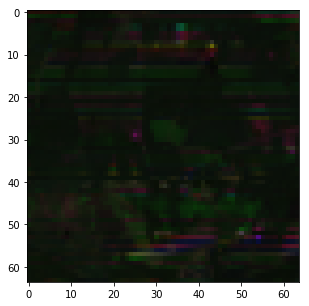

In [48]:
fig, axs = plt.subplots(1, 1, figsize=(18, 5)) 

axs.imshow(im_batch[0,:,:,::-1])

## Let's get to the CNN Development!!

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [7]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

### prep some of the hyperparameters

In [18]:
batch_size = 25
label_image[label_image == 255] = 1
num_classes = len(np.unique(label_image))
epochs = 50

# input image dimensions
tile_side = 25
img_rows, img_cols = tile_side, tile_side
img_bands = 3

weight_decay = 0.01

input_shape = (img_rows, img_cols, img_bands)
print(num_classes)

23


### build the model

This is just a simple CNN model but it should be able to perform well above random when predicting landcover types if everything is correct thus far.

In [31]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(22, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 62, 62, 64)        4096      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 60, 60, 22)        12694     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 22)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 30, 22)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 64)        12736     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 64)        0         
__________

In [24]:
from keras import regularizers
from keras.layers import Activation, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 32)        2048      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
__________

#### Generate the train/validation pixel locations to train with

In [14]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=5000, val_count=500, tile_size=tile_side)

#### set up the remaining model hyperparameters and compile

In [38]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#sgd = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

#### TRAIN THE MODEL!

In [39]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#sgd = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50


ResourceExhaustedError: OOM when allocating tensor with shape[25,22,60,60] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv2d_22/convolution}} = Conv2D[T=DT_FLOAT, _class=["loc:@training_3/SGD/gradients/conv2d_22/convolution_grad/Conv2DBackpropFilter"], data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_21/Relu, conv2d_22/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node loss_3/mul/_687}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_999_loss_3/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


### Now let's evaluate the Model

We'll just generate 500 test pixels to evaluate it on

Keras has a built in evaluate_generator function and because we told it above to use accuracy as a metric this function automatically outputs categorical accuracy which is what we want.

In [ ]:
model.evaluate_generator(generator=tile_generator(landsat_datasets, label_dataset, 11, 11, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

So in this simple model we're getting 37% accuracy across 23 classes which is well above the random accuracy which would be around 4% (aka 1/23). That means we're in business!

### Evaluating the model ourselves

If we wanted to run this evaluation and take a look at specific predictions and labels we can do that below (albeit more inefficiently) just to get an intuitive understanding of what is going wrong.

In [36]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets, label_dataset, 25, 25, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)
eval_generator = tile_generator(landsat_datasets, label_dataset, 25, 25, test_px, batch_size=1)
labels = np.empty(predictions.shape)
count = 0
while count < len(test_px):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

200/200 [==============================] - 12s 60ms/step


In [32]:
eval_generator = tile_generator(landsat_datasets, label_dataset, 25, 25, test_px, batch_size=1)

In [35]:
print(predictions)

[2.241179084777832, 0.24839999936521054]


In [37]:
labels = np.empty(predictions.shape)
count = 0
while count < len(test_px):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1

In [38]:
labels.shape

(5000, 23)

In [39]:
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

In [40]:
correct_predictions = np.zeros(pred_index.shape)
correct_predictions[label_index == pred_index] = 1

In [41]:
np.count_nonzero(correct_predictions) / len(test_px)

0.2484

Now maybe more informatively let's build a confusion matrix using the scikit-learn function.

Read the docs here and make this more informative by following some of their examples: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

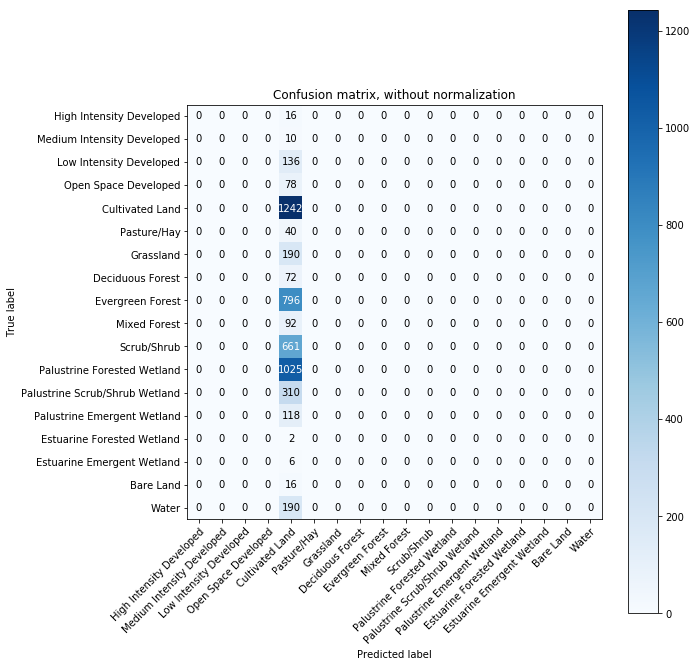

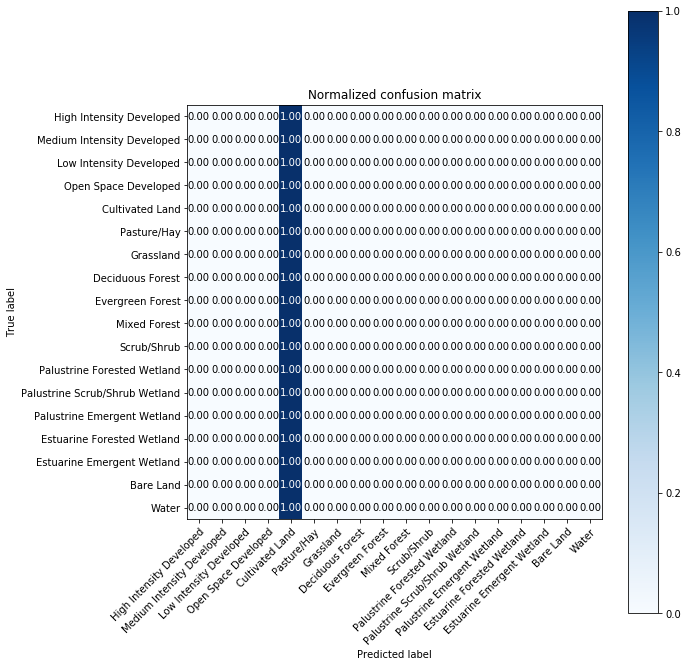

In [42]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

## Scikit-learn ML Approaches

In [ ]:
def pixel_generator(image_datasets, label_dataset, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
  
    image_batch = np.zeros((batch_size, band_count))
    label_batch = np.zeros((batch_size, class_count))
    b = 0
    while b < batch_size:
        # if we're at the end  of the data just restart
        if i >= len(pixel_locations):
            i=0
        c, r = pixel_locations[i][0]
        dataset_index = pixel_locations[i][1]
        i += 1
        tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c, r, 1, 1))
        if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
            pass
        elif np.isnan(tile).any() == True or -9999 in tile: 
            # we don't want tiles containing nan or -9999 this comes from edges
            # this also takes a while and is inefficient
            pass
        else:
            tile = adjust_band(tile)
            # reshape from raster format to image format
            reshaped_tile = reshape_as_image(tile)

            # find gps of that pixel within the image
            (x, y) = image_datasets[dataset_index].xy(r, c)

            # convert the point we're sampling from to the same projection as the label dataset if necessary
            inProj = Proj(image_datasets[dataset_index].crs)
            if inProj != outProj:
                x,y = transform(inProj,outProj,x,y)

            # reference gps in label_image
            row, col = label_dataset.index(x,y)

            # find label
            label = label_image[:, row, col]
            # if this label is part of the unclassified area then ignore
            if label == 0 or np.isnan(label).any() == True:
                pass
            else:
                # add label to the batch in a one hot encoding style
                label_batch[b][label] = 1
                image_batch[b] = reshaped_tile
                b += 1
    return (image_batch, label_batch)
              

In [ ]:
def sk_tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]
    label_image = label_dataset.read()
    label_image[label_image == 255] = 1

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    class_count = len(np.unique(label_image))
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height * tile_width * band_count))
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                # somehow we're randomly getting tiles without the correct dimensions
                # I assume it is when the tiles are on the edge
                pass
            else:
                tile = adjust_band(tile)
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile.flatten()
                    b += 1
        return (image_batch, label_batch)


### Prep Data for training and validation

In [10]:
train_px, val_px = gen_pixel_locations([landsat_dataset], 50000, 1000, 1)

NameError: name 'landsat_dataset' is not defined

In [ ]:
batch_size = 50000
sk_im_batch, sk_label_batch = pixel_generator([landsat_dataset], label_dataset, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

In [ ]:
batch_size = 1000
sk_im_batch_val, sk_label_batch_val = pixel_generator([landsat_dataset], label_dataset, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

### K Nearest Neighbors

In [ ]:
from sklearn import neighbors, datasets

n_neighbors = 50

# we create an instance of Neighbours Classifier and fit the data.
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))


In [ ]:
label_index = np.argmax(sk_label_batch_val, axis=1)

clf.score(sk_im_batch_val, label_index)

In [ ]:
pred_index = clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [ ]:
plt.hist(np.argmax(sk_label_batch_val, axis=1), bins=20)

In [ ]:
plt.hist(pred_index, bins=20)

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [ ]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

In [ ]:
rf.score(sk_im_batch_val, label_index)

In [ ]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

In [ ]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [ ]:
plt.hist(pred_index, bins=20)

#### Creating training data that contains a 3x3 tile

In [ ]:
batch_size = 50000
sk_im_batch, sk_label_batch = sk_tile_generator([landsat_dataset], label_dataset, 3, 3, train_px, batch_size)
print(sk_im_batch.shape, sk_label_batch.shape)

In [ ]:
batch_size = 1000
sk_im_batch_val, sk_label_batch_val = sk_tile_generator([landsat_dataset], label_dataset, 3, 3, val_px, batch_size)
print(sk_im_batch_val.shape, sk_label_batch_val.shape)

In [ ]:
rf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
rf = rf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [ ]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

In [ ]:
label_index = np.argmax(sk_label_batch_val, axis=1)

rf.score(sk_im_batch_val, label_index)

In [ ]:
bands = [1, 2, 3, 4, 5, 6, 7]

for b, imp in zip(bands, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

In [ ]:
pred_index = rf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

### SVM

In [ ]:
from sklearn import svm
svm_clf = svm.SVC(gamma='scale')
svm_clf.fit(sk_im_batch, np.argmax(sk_label_batch, axis=1))

In [ ]:
svm_clf.score(sk_im_batch_val, np.argmax(sk_label_batch_val, axis=1))

In [ ]:
pred_index = svm_clf.predict(sk_im_batch_val)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [ ]:
# get a balanced percent of each class
# look at the classes that are consistently mis classified
# think about adding NDVI or taking out bands


## VGGNet16

In [56]:
from keras.applications import VGG16
input_shape = (32,32,3)
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [42]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=50000, val_count=5000, tile_size=tile_side)

In [57]:
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
    

In [44]:
vggmodel = keras.Sequential()
vggmodel.add(vgg_conv)
vggmodel.add(Flatten())
vggmodel.add(Dense(1024, activation='relu'))
vggmodel.add(Dropout(0.5))
vggmodel.add(Dense(num_classes, activation='softmax'))
vggmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 23)                23575     
Total params: 15,263,575
Trainable params: 7,628,311
Non-trainable params: 7,635,264
_________________________________________________________________


In [45]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
metrics=['accuracy']
batch_size = 25

vggmodel.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)

In [46]:
history = vggmodel.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, 32, 32, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=300, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, 32, 32, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/300
2000/2000 [==============================] - 78s 39ms/step - loss: 1.9195 - acc: 0.3645 - val_loss: 1.8984 - val_acc: 0.3578
Epoch 2/300
2000/2000 [==============================] - 70s 35ms/step - loss: 1.8355 - acc: 0.3879 - val_loss: 1.8483 - val_acc: 0.3906
Epoch 3/300
2000/2000 [==============================] - 70s 35ms/step - loss: 1.8117 - acc: 0.3917 - val_loss: 1.8651 - val_acc: 0.3718
Epoch 4/300
2000/2000 [==============================] - 70s 35ms/step - loss: 1.7933 - acc: 0.3971 - val_loss: 1.8530 - val_acc: 0.3832
Epoch 5/300
2000/2000 [==============================] - 70s 35ms/step - loss: 1.7844 - acc: 0.4010 - val_loss: 1.8998 - val_acc: 0.3944
Epoch 6/300
2000/2000 [==============================] - 70s 35ms/step - loss: 1.7687 - acc: 0.4059 - val_loss: 1.8821 - val_acc: 0.3522
Epoch 7/300
2000/2000 [==============================] - 69s 35ms/step - loss: 1.7722 - acc: 0.4066 - val_loss: 1.8443 - val_acc: 0.3996
Epoch 8/300
2000/2000 [==================

2000/2000 [==============================] - 70s 35ms/step - loss: 2.1740 - acc: 0.2553 - val_loss: 2.1778 - val_acc: 0.2548
Epoch 120/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1724 - acc: 0.2559 - val_loss: 2.1798 - val_acc: 0.2548
Epoch 121/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1715 - acc: 0.2560 - val_loss: 2.2110 - val_acc: 0.1832
Epoch 122/300
2000/2000 [==============================] - 69s 35ms/step - loss: 2.1654 - acc: 0.2595 - val_loss: 2.2092 - val_acc: 0.1836
Epoch 123/300
2000/2000 [==============================] - 69s 34ms/step - loss: 2.1603 - acc: 0.2596 - val_loss: 2.1833 - val_acc: 0.2552
Epoch 124/300
2000/2000 [==============================] - 69s 34ms/step - loss: 2.1730 - acc: 0.2569 - val_loss: 2.1809 - val_acc: 0.2552
Epoch 125/300
2000/2000 [==============================] - 69s 34ms/step - loss: 2.1768 - acc: 0.2553 - val_loss: 2.1771 - val_acc: 0.2544
Epoch 126/300
2000/2000 [================

2000/2000 [==============================] - 70s 35ms/step - loss: 2.1724 - acc: 0.2552 - val_loss: 2.1796 - val_acc: 0.2590
Epoch 179/300
2000/2000 [==============================] - 71s 35ms/step - loss: 2.1701 - acc: 0.2574 - val_loss: 2.2168 - val_acc: 0.1834
Epoch 180/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1636 - acc: 0.2580 - val_loss: 2.1880 - val_acc: 0.1850
Epoch 181/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1620 - acc: 0.2592 - val_loss: 2.1817 - val_acc: 0.2578
Epoch 182/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1786 - acc: 0.2544 - val_loss: 2.1801 - val_acc: 0.2550
Epoch 183/300
2000/2000 [==============================] - 69s 34ms/step - loss: 2.1789 - acc: 0.2543 - val_loss: 2.1814 - val_acc: 0.2564
Epoch 184/300
2000/2000 [==============================] - 69s 34ms/step - loss: 2.1762 - acc: 0.2560 - val_loss: 2.1777 - val_acc: 0.2552
Epoch 185/300
2000/2000 [================

2000/2000 [==============================] - 70s 35ms/step - loss: 2.1670 - acc: 0.2585 - val_loss: 2.1944 - val_acc: 0.1852
Epoch 238/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1623 - acc: 0.2584 - val_loss: 2.1666 - val_acc: 0.2602
Epoch 239/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1715 - acc: 0.2566 - val_loss: 2.1725 - val_acc: 0.2576
Epoch 240/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1782 - acc: 0.2541 - val_loss: 2.1828 - val_acc: 0.2538
Epoch 241/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1779 - acc: 0.2547 - val_loss: 2.1733 - val_acc: 0.2566
Epoch 242/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1778 - acc: 0.2553 - val_loss: 2.1759 - val_acc: 0.2558
Epoch 243/300
2000/2000 [==============================] - 69s 35ms/step - loss: 2.1782 - acc: 0.2543 - val_loss: 2.1761 - val_acc: 0.2562
Epoch 244/300
2000/2000 [================

2000/2000 [==============================] - 70s 35ms/step - loss: 2.1612 - acc: 0.2586 - val_loss: 2.1815 - val_acc: 0.2558
Epoch 297/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1801 - acc: 0.2532 - val_loss: 2.1650 - val_acc: 0.2602
Epoch 298/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1788 - acc: 0.2534 - val_loss: 2.1611 - val_acc: 0.2608
Epoch 299/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1783 - acc: 0.2545 - val_loss: 2.1674 - val_acc: 0.2590
Epoch 300/300
2000/2000 [==============================] - 70s 35ms/step - loss: 2.1777 - acc: 0.2542 - val_loss: 2.1750 - val_acc: 0.2548


### Evaluate the model

In [55]:
test_px, val_px = gen_pixel_locations(landsat_datasets, train_count=500, val_count=0, tile_size=64)

100%|██████████| 4/4 [00:42<00:00, 10.60s/it]


In [49]:
vggmodel.evaluate_generator(generator=tile_generator(landsat_datasets, label_dataset, 32, 32, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

20/20 [==============================] - 8s 375ms/step


[2.177214562892914, 0.27999999821186067]

## InceptionV3

In [15]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
base_model = InceptionV3(weights='imagenet', include_top=False)

In [16]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [17]:
inception_model = keras.Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
inception_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
inception_model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, 64, 64, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=50, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, 64, 64, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/50


/usr/local/lib/python3.5/dist-packages/rasterio/plot.py:319: RuntimeWarning: overflow encountered in short_scalars
  band_normed = (band - imin) / (imax - imin)


## Simple

In [23]:
model = Sequential()

model.add(Conv2D(50, kernel_size=(6, 6), activation='relu', input_shape=input_shape))

model.add(Flatten())
model.add(Dense(46, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 20, 20, 50)        5450      
_________________________________________________________________
flatten_6 (Flatten)          (None, 20000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 46)                920046    
_________________________________________________________________
dropout_9 (Dropout)          (None, 46)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 23)                1081      
Total params: 926,577
Trainable params: 926,577
Non-trainable params: 0
_________________________________________________________________


In [24]:
train_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=50000, val_count=5000, tile_size=tile_side)

100%|██████████| 4/4 [00:56<00:00, 14.33s/it]


In [25]:
sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#sgd = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)


In [26]:
model.fit_generator(generator=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=300, verbose=1,
                    validation_data=tile_generator(landsat_datasets, label_dataset, tile_side, tile_side, val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/300
2000/2000 [==============================] - 72s 36ms/step - loss: 2.4887 - acc: 0.2543 - val_loss: 2.3578 - val_acc: 0.2796
Epoch 2/300
2000/2000 [==============================] - 64s 32ms/step - loss: 2.3084 - acc: 0.2757 - val_loss: 2.3573 - val_acc: 0.2446
Epoch 3/300
2000/2000 [==============================] - 63s 32ms/step - loss: 2.3166 - acc: 0.2476 - val_loss: 2.2417 - val_acc: 0.3078
Epoch 4/300
2000/2000 [==============================] - 63s 32ms/step - loss: 2.2159 - acc: 0.2808 - val_loss: 2.1981 - val_acc: 0.3056
Epoch 5/300
2000/2000 [==============================] - 63s 32ms/step - loss: 2.2003 - acc: 0.2819 - val_loss: 2.1905 - val_acc: 0.3136
Epoch 6/300
2000/2000 [==============================] - 63s 32ms/step - loss: 2.1805 - acc: 0.2889 - val_loss: 2.1790 - val_acc: 0.2998
Epoch 7/300
2000/2000 [==============================] - 63s 32ms/step - loss: 2.1640 - acc: 0.2955 - val_loss: 2.1598 - val_acc: 0.2950
Epoch 8/300
2000/2000 [==================

2000/2000 [==============================] - 65s 33ms/step - loss: 2.2593 - acc: 0.2478 - val_loss: 2.2956 - val_acc: 0.1942
Epoch 61/300
2000/2000 [==============================] - 65s 33ms/step - loss: 2.2630 - acc: 0.2490 - val_loss: 2.3074 - val_acc: 0.1946
Epoch 62/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2665 - acc: 0.2483 - val_loss: 2.3059 - val_acc: 0.1938
Epoch 63/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2766 - acc: 0.2480 - val_loss: 2.3339 - val_acc: 0.1952
Epoch 64/300
2000/2000 [==============================] - 65s 33ms/step - loss: 2.2752 - acc: 0.2478 - val_loss: 2.3030 - val_acc: 0.1940
Epoch 65/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2639 - acc: 0.2493 - val_loss: 2.3007 - val_acc: 0.1940
Epoch 66/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2609 - acc: 0.2490 - val_loss: 2.3016 - val_acc: 0.1948
Epoch 67/300
2000/2000 [=======================

2000/2000 [==============================] - 64s 32ms/step - loss: 2.2544 - acc: 0.2475 - val_loss: 2.2895 - val_acc: 0.2434
Epoch 120/300
2000/2000 [==============================] - 64s 32ms/step - loss: 2.2563 - acc: 0.2471 - val_loss: 2.2912 - val_acc: 0.2424
Epoch 121/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2554 - acc: 0.2473 - val_loss: 2.2974 - val_acc: 0.2426
Epoch 122/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2584 - acc: 0.2463 - val_loss: 2.2999 - val_acc: 0.2432
Epoch 123/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2600 - acc: 0.2483 - val_loss: 2.2983 - val_acc: 0.2418
Epoch 124/300
2000/2000 [==============================] - 66s 33ms/step - loss: 2.2601 - acc: 0.2470 - val_loss: 2.2939 - val_acc: 0.2428
Epoch 125/300
2000/2000 [==============================] - 66s 33ms/step - loss: 2.2575 - acc: 0.2468 - val_loss: 2.2915 - val_acc: 0.2436
Epoch 126/300
2000/2000 [================

2000/2000 [==============================] - 64s 32ms/step - loss: 2.2579 - acc: 0.2462 - val_loss: 2.2920 - val_acc: 0.2426
Epoch 179/300
2000/2000 [==============================] - 64s 32ms/step - loss: 2.2595 - acc: 0.2457 - val_loss: 2.2928 - val_acc: 0.2436
Epoch 180/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2586 - acc: 0.2457 - val_loss: 2.2917 - val_acc: 0.2438
Epoch 181/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2591 - acc: 0.2464 - val_loss: 2.2965 - val_acc: 0.2428
Epoch 182/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2584 - acc: 0.2452 - val_loss: 2.2931 - val_acc: 0.2432
Epoch 183/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2588 - acc: 0.2459 - val_loss: 2.2952 - val_acc: 0.2424
Epoch 184/300
2000/2000 [==============================] - 65s 33ms/step - loss: 2.2572 - acc: 0.2456 - val_loss: 2.2912 - val_acc: 0.2436
Epoch 185/300
2000/2000 [================

2000/2000 [==============================] - 63s 32ms/step - loss: 2.2579 - acc: 0.2459 - val_loss: 2.2972 - val_acc: 0.2400
Epoch 238/300
2000/2000 [==============================] - 64s 32ms/step - loss: 2.2564 - acc: 0.2450 - val_loss: 2.2958 - val_acc: 0.2416
Epoch 239/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2565 - acc: 0.2461 - val_loss: 2.2960 - val_acc: 0.2422
Epoch 240/300
2000/2000 [==============================] - 65s 33ms/step - loss: 2.2565 - acc: 0.2459 - val_loss: 2.2958 - val_acc: 0.2418
Epoch 241/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2557 - acc: 0.2451 - val_loss: 2.2942 - val_acc: 0.2414
Epoch 242/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2570 - acc: 0.2460 - val_loss: 2.2963 - val_acc: 0.2430
Epoch 243/300
2000/2000 [==============================] - 64s 32ms/step - loss: 2.2556 - acc: 0.2459 - val_loss: 2.2926 - val_acc: 0.1954
Epoch 244/300
2000/2000 [================

2000/2000 [==============================] - 65s 32ms/step - loss: 2.2522 - acc: 0.2464 - val_loss: 2.3034 - val_acc: 0.2418
Epoch 297/300
2000/2000 [==============================] - 64s 32ms/step - loss: 2.2527 - acc: 0.2464 - val_loss: 2.2954 - val_acc: 0.2438
Epoch 298/300
2000/2000 [==============================] - 64s 32ms/step - loss: 2.2537 - acc: 0.2464 - val_loss: 2.2954 - val_acc: 0.2418
Epoch 299/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2535 - acc: 0.2466 - val_loss: 2.2938 - val_acc: 0.2418
Epoch 300/300
2000/2000 [==============================] - 65s 32ms/step - loss: 2.2526 - acc: 0.2460 - val_loss: 2.2966 - val_acc: 0.2412


In [22]:
model.evaluate_generator(generator=tile_generator(landsat_datasets, label_dataset, 25, 25, val_px, batch_size), 
                        steps=len(val_px) // batch_size,
                         verbose=1)

20/20 [==============================] - 8s 384ms/step


[1.9961568713188171, 0.3520000010728836]

In [27]:
test_px, val_px = gen_pixel_locations(image_datasets=landsat_datasets, 
                                       train_count=5000, val_count=0, tile_size=25)

100%|██████████| 4/4 [00:41<00:00, 10.32s/it]


In [33]:
predictions = model.evaluate_generator(generator=tile_generator(landsat_datasets, label_dataset, 25, 25, test_px, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

  6/200 [..............................] - ETA: 3:49

/usr/local/lib/python3.5/dist-packages/rasterio/plot.py:319: RuntimeWarning: overflow encountered in short_scalars
  band_normed = (band - imin) / (imax - imin)


200/200 [==============================] - 12s 61ms/step
